### Data Import 

Import the required packages

In [3]:

import numpy as np # Simple linear algebra calculations
import pandas as pd # pandas to read csv files 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
import re
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer
from tqdm import tqdm

Import the dataset, which consists on training set labeled and an unlabeled test set. 

In [4]:
import os
for dirname, _, filenames in os.walk('/Users/aymentiouiri/Desktop/workspace/Sentiment-Analysis/data/tweet-hatred-speech'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/aymentiouiri/Desktop/workspace/Sentiment-Analysis/data/tweet-hatred-speech/test.csv
/Users/aymentiouiri/Desktop/workspace/Sentiment-Analysis/data/tweet-hatred-speech/train.csv


In [5]:
df = pd.read_csv('/Users/aymentiouiri/Desktop/workspace/Sentiment-Analysis/data/tweet-hatred-speech/train.csv')
test = pd.read_csv('/Users/aymentiouiri/Desktop/workspace/Sentiment-Analysis/data/tweet-hatred-speech/test.csv')

### Data Quality 

We are going to investigate the quality of the dataset by  checking for null values, the structure of the data, outliers and the label distribution.


In [6]:
df.head(10) #check for anomalies by looking at the top 20 tweets. 

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [7]:
# check for null values 
df.isnull().sum() # this checks whether for each column we have null values and sums the total number

id       0
label    0
tweet    0
dtype: int64

In [8]:
# check for the label distribution
df['label'].value_counts() # this counts the number of elements in the label column by category

label
0    29720
1     2242
Name: count, dtype: int64

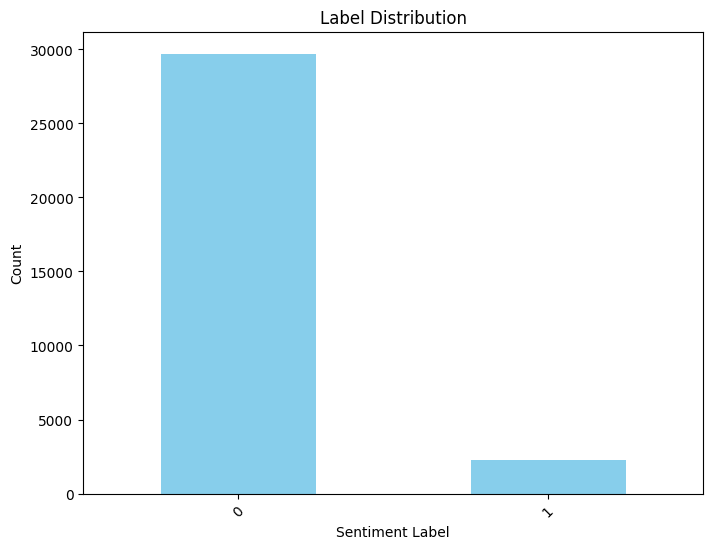

In [9]:
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We clearly see that the dataset is unbalanced. We might consider to use upsampling for category 1 in order to have a balanced training set.

In [10]:
# check for outliers, a tweet would be considered as outlier if the length of the tweet exceeds 280 
df['text_length'] = df['tweet'].apply(lambda x: len(str(x)))
text_length_stats = df['text_length'].describe()
print("Text Length Statistics:")
print(text_length_stats)

# The statistic description shows that the maximum is 274 characters



Text Length Statistics:
count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: text_length, dtype: float64


([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

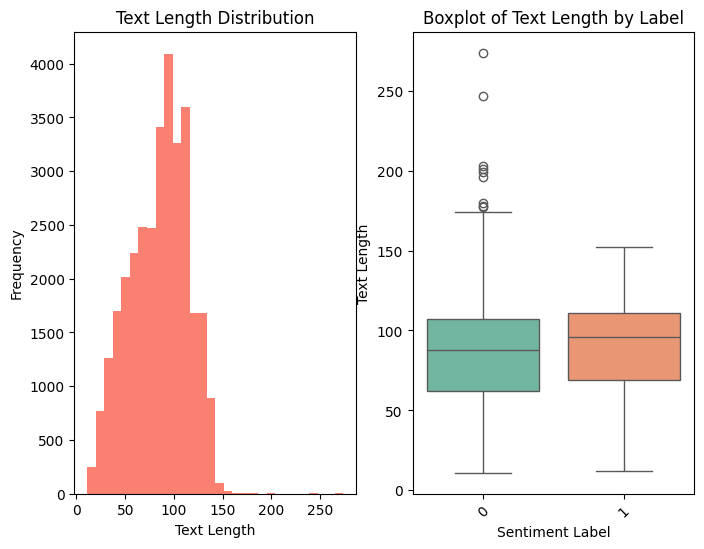

In [11]:
# Plot text length distribution
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
plt.hist(df['text_length'], bins=30, color='salmon')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.subplot(1,2,2)
#plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='text_length', data=df, palette='Set2')
plt.title('Boxplot of Text Length by Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Text Length')
plt.xticks(rotation=45)
#plt.show()


We distinguish the presence of some outliers, we will see if we need to remove them from our dataset, since they do not influence the outcome of the analysis

### Data Cleanning

In [12]:
# We first need to combinne the training and test set for cleaning 

alltext = df['tweet'].tolist() + test['tweet'].tolist()
len(alltext)

49159

In [13]:
nltk.download('stopwords') # stopwords is used for finding the most common words and remove them. "I","me","my","myself" 
stopword = nltk.corpus.stopwords.words('english')
stopword.remove('not') # we remove not because it has something to do with the sentiment
processed_text = []
for text_ in alltext:
    text_ = re.sub(r'@[\w]*', '', text_)  # Removing Twitter Handles (@user)
    text_ = re.sub(r'http\S+', '', text_)  # Removing URLs from text 
    text_ = re.sub(r'[^A-Za-z#]', ' ', text_)  # Removing Punctuations, Numbers, and Special Characters
    text_ = " ".join(i.lower() for i in text_.split() if i.lower() not in stopword)  # Removing stopwords
    processed_text.append(text_)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aymentiouiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
if "not" in stopword:
    print("yes")
else:
    print("no")


no


In [15]:
alltext[0],processed_text[0]

(' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 'father dysfunctional selfish drags kids dysfunction #run')

### Vectorization

1-TfidfVectorizer from scikit-learn converts a collection of processed text data into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.

2-fit_transform(processed_text): This method computes the TF-IDF values for each term in the processed text and returns a sparse matrix where each row represents a document (or text sample) and each column represents a term. The matrix is transformed in such a way that each term frequency is weighted by its inverse document frequency.

In [16]:
# Term Frequency inverse Document frequency conversion TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=1000) # transofrm to tf-idf
tfidf_matrix = vectorizer.fit_transform(processed_text).toarray()

In [19]:
vectorizer,tfidf_matrix.shape

(TfidfVectorizer(max_features=1000, min_df=2, ngram_range=(1, 2)),
 (49159, 1000))

In [22]:
tokenized_text = [text.split() for text in processed_text]
w2v_model = gensim.models.Word2Vec(tokenized_text, min_count=1, vector_size=100, window=5, sg=1)
w2v_words = list(w2v_model.wv.index_to_key)

In [23]:
# Generate vectors using Word2Vec
vectors = []
for sent in tqdm(tokenized_text):
    sent_vec = np.zeros(100)
    count = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count  # Normalize
    vectors.append(sent_vec)

100%|██████████| 49159/49159 [01:49<00:00, 447.70it/s]


In [24]:
# Remove duplicate rows
df.drop_duplicates(subset=['tweet'], keep='first', inplace=True)

# Reset DataFrame index
df.reset_index(drop=True, inplace=True)

# Assign vectors to DataFrame
df['vectors'] = vectors[:len(df)]

# Balancing the classes by upsampling the minority class
major_class_0, major_class_1 = df.label.value_counts()
df_major = df[df['label'] == 0]
df_minor = df[df['label'] == 1]
df_minor_upsampled = resample(df_minor, replace=True, n_samples=major_class_0)
df_upsampled = pd.concat([df_major, df_minor_upsampled])

In [25]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(df_upsampled['vectors'].tolist(), df_upsampled['label'], test_size=0.2)

In [26]:
# Model training and evaluation
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_pred, y_test)
print('Accuracy Score:', acc)
y_proba = model.predict_proba(x_test)
f1_scor = f1_score(y_pred, y_test)
print('F1 Score:', f1_scor)

Accuracy Score: 0.977196329608431
F1 Score: 0.9771423367635006
